All library imports have been moved to the first cell for clear visualization of everything being imported and to minimize repeat import of libraries. At the bottom the cell you wll find the tutorial we used to guide us through the process. 

In [1]:
import tensorflow as tf
import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from datasets import load_dataset 
from datasets import load_metric
from transformers import AutoImageProcessor
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer
import torch

print(tf.__version__)
#https://huggingface.co/docs/transformers/notebooks
#https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/image_classification.ipynb#scrollTo=N3yJFIIP_k01



2.15.0


Here we are using the dataset library to load our main folder containing the images we will use to train our model. We are also loading the accuracy metric. The dataset istelf is a Dataset Dictionary. The commented out code below are used to show how to access elements inside the Dataset

Resolving data files:   0%|          | 0/839 [00:00<?, ?it/s]

C:\Users\danger bravo\AppData\Local\Temp\ipykernel_19388\3440182576.py:2: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")


DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 838
    })
})
{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=100x100 at 0x2C7FC949F70>, 'label': 0}
<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=100x100 at 0x2C7FC949F70>
0


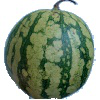

In [2]:
dataset = load_dataset("likeDislike", data_dir=".")
metric = load_metric("accuracy")
print(dataset)

#example = dataset["train"][11]
#print(example)
#dataset["train"].features
#print(example['image'])
#print(example['label'])
#dataset["train"][837]['image']

Here we are converting the dataset label values into strings and creating a  dictionary holding their binary value. 0 = FoodDislikem 1 = FoodLike

In [3]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

print(id2label[1])
print(id2label[0])

FoodLike
FoodDislike


In [322]:
print(id2label)
print(label2id)

{0: 'FoodDislike', 1: 'FoodLike'}
{'FoodDislike': 0, 'FoodLike': 1}


PREPROCESSING THE DATA:
First we load the model we will use to train on.
Then we used to functions to normalize the images, which involves resizing, random flipping of images, cropping images, and color corrections.


In [4]:
#Loading an Image Processor
image_processor = AutoImageProcessor.from_pretrained("google/vit-base-patch16-224")

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
if "height" in image_processor.size:
    size = (image_processor.size["height"], image_processor.size["width"])
    crop_size = size
    max_size = None
elif "shortest_edge" in image_processor.size:
    size = image_processor.size["shortest_edge"]
    crop_size = (size, size)
    max_size = image_processor.size.get("longest_edge")

train_transforms = Compose(
        [
            RandomResizedCrop(crop_size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(size),
            CenterCrop(crop_size),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

We will now split our data into training and validations sets. 

In [5]:
# split up training into training + validation
splits = dataset["train"].train_test_split(test_size=0.1)
train_ds = splits['train']
val_ds = splits['test']
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

This is a visualzation of an image as pixel values

In [6]:
train_ds[0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=100x100>,
 'label': 1,
 'pixel_values': tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          ...,
          [ 0.9843,  0.9843,  0.9843,  ..., -0.3961, -0.4039, -0.4039],
          [ 0.9765,  0.9765,  0.9765,  ..., -0.3882, -0.3961, -0.3961],
          [ 0.9765,  0.9765,  0.9765,  ..., -0.3882, -0.3961, -0.3961]],
 
         [[ 1.0000,  1.0000,  1.0000,  ...,  0.9843,  0.9843,  0.9843],
          [ 1.0000,  1.0000,  1.0000,  ...,  0.9843,  0.9843,  0.9843],
          [ 1.0000,  1.0000,  1.0000,  ...,  0.9843,  0.9843,  0.9843],
          ...,
          [ 0.9922,  0.9922,  0.9922,  ..., -0.4980, -0.5059, -0.5059],
          [ 0.9843,  0.9843,  0.9922,  ..., -0.4902, -0.4980, -0.4980],
          [ 0.9843,  0.9843,  0.9922,  ..., -0.4902, -0.4980, -0.4980]]

TRAINING THE MODEL: now we will combind our labels we created above, our model of choice, and ignore mismatched sizes = True, since we are using a model that has been trained once already.

In [7]:
model = AutoModelForImageClassification.from_pretrained(
    "google/vit-base-patch16-224", 
    label2id=label2id,
    id2label=id2label,
    ignore_mismatched_sizes = True, # provide this in case you're planning to fine-tune an already fine-tuned checkpoint
)


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


We are defining the TrainingArguments that will be used in our newly trained model, this incldues: Our model's name, how we are evaluating our model, batch size, number of epochs to run, and whether we want to submit it online.

In [8]:
model_name = "google/vit-base-patch16-224".split("/")[-1]

args = TrainingArguments(
    f"{model_name}-food-like-dislike-5",
    remove_unused_columns=False,
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=32,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=32,
    num_train_epochs=5,
    warmup_ratio=0.1,
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
)

This function is used to compute the metrics from our predictions.

In [9]:
# the compute_metrics function takes a Named Tuple as input:
# predictions, which are the logits of the model as Numpy arrays,
# and label_ids, which are the ground-truth labels as Numpy arrays.
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

This function is used to batch pixel values and labels together

In [10]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example["label"] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

All the functions,arguments, and datasets created above are now added to our Trainer and ran.

In [11]:
trainer = Trainer(
    model,
    args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

We can see our model ran below and see specifics in how each epoch changed our model. Accuracy remained the same, Validation Loss decreased, and Traning Loss decreased, so we know our model improved each epoch.

In [12]:
train_results = trainer.train()
# rest is optional but nice to have
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
trainer.save_state()

***** train metrics *****
  epoch                    =         5.0
  total_flos               = 272081048GF
  train_loss               =      0.1955
  train_runtime            =  0:49:12.40
  train_samples_per_second =       1.277
  train_steps_per_second   =        0.01


We can check with the evaluate method that our Trainer did reload the best model properly (if it was not the last one):

In [13]:
metrics = trainer.evaluate()
# some nice to haves:
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  epoch                   =        5.0
  eval_accuracy           =        1.0
  eval_loss               =     0.3176
  eval_runtime            = 0:00:22.26
  eval_samples_per_second =      3.773
  eval_steps_per_second   =      0.135


Evaluation of model:
Below we see that the evaluation data was stored in Json dictionary format, so we can use that to load the evaluation logs and see how our model performed.

In [20]:
metrics['eval_loss']

0.31755372881889343

In [26]:
train_results.metrics

{'train_runtime': 2952.4049,
 'train_samples_per_second': 1.277,
 'train_steps_per_second': 0.01,
 'total_flos': 2.9214480084701184e+17,
 'train_loss': 0.19546856532494228,
 'epoch': 5.0}

Here we load the JSON file containing our eval data and we retrieve the epoch, accuracy, and loss data.

In [51]:
import json
file_path = r'C:\Users\danger bravo\PYTHON AI, DATA SCIENCE\Python Train Model\vit-base-patch16-224-food-like-dislike-5\trainer_state.json'
with open(file_path, 'r') as file:
    data = json.load(file)
#print(data)
dataplot = data['log_history']
ecount= 1.0
epochX = []
evelAcc = []
evalLoss = []
for epoch in dataplot:
    #print(epoch)
    if 'eval_accuracy' not in epoch and 'eval_loss' not in epoch:
        continue
    if epoch['epoch'] == ecount:
        ecount+=1.0
        epochX.append(epoch['epoch'])
        evelAcc.append(epoch['eval_accuracy'])
        evalLoss.append(epoch['eval_loss'])
print(epochX)
print(evelAcc)
print(evalLoss)


[1.0, 2.0, 3.0, 4.0, 5.0]
[1.0, 1.0, 1.0, 1.0, 1.0]
[0.31755372881889343, 0.08570505678653717, 0.030042793601751328, 0.01455193292349577, 0.011930791661143303]


DATA ANALYSIS: We then plot the data retrieved to visualize how our model progressed overtime.

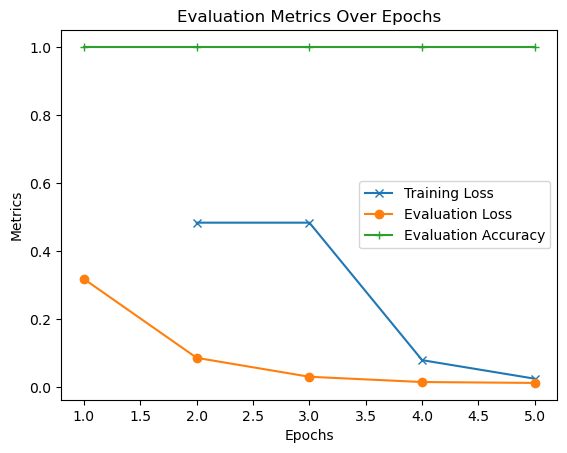

In [293]:
import matplotlib.pyplot as plt

trainLoss = [0.483200,0.483200,0.078900,0.024300]

plt.plot(epochX[1:], trainLoss, label='Training Loss', marker='x')

plt.plot(epochX, evalLoss, label='Evaluation Loss', marker='o')

plt.plot(epochX, evelAcc, label='Evaluation Accuracy', marker='+')

plt.xlabel('Epochs')
plt.ylabel('Metrics')
plt.title('Evaluation Metrics Over Epochs')

plt.legend()

plt.show()

We are creating a pipeline of our new model, so it can be used to classify the test images we will provide.

In [65]:
from transformers import pipeline

pipe = pipeline("image-classification", r"C:\Users\danger bravo\PYTHON AI, DATA SCIENCE\Python Train Model\vit-base-patch16-224-food-like-dislike-5",feature_extractor=image_processor)

Our classifer function is performing many actions to our training images. First it is locating the score and label for our image with the highest confidence score. It then appends the score and label, and will count the amount of times a label is FoodLike and FoodDislike. Lastly, it will plot 9 random images from our training folder in a 3x3 matrix.

In [286]:
import glob

def classifer(imgList:list): 
    from PIL import Image
    import random
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    
    scores = []
    labels = []
    lcounter =0 
    dcounter = 0
    
    for img in imgList:
        url = r'C:\Users\danger bravo\PYTHON AI, DATA SCIENCE\Python Train Model'
        image_path = url+'\\'+img
        image = Image.open(image_path).convert('RGB')
        x = pipe(image)
        score = [x][0][0]['score']
        scores.append(score)
        label = [x][0][0]['label']
        labels.append(label)
        if label == "FoodDislike": 
            dcounter+=1
        else:
            lcounter+=1
    randomImages = random.sample(imgList, 9)

    plt.figure(figsize=(10, 10))
    for i, imagePath in enumerate(randomImages):
        ax = plt.subplot(3, 3, i + 1)
        img = mpimg.imread(imagePath)
        plt.imshow(img)
        plt.axis("off")

    plt.show()
    
    return scores, labels, lcounter, dcounter

Our makePlots function will take the data collected above as a DataFrame and plot it in a Box Plot for Each label and also plot a pie chart showing the amount of each label.

In [277]:
#https://matplotlib.org/stable/users/explain/colors/colors.html#sphx-glr-users-explain-colors-colors-py
#https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.boxplot.html
#https://matplotlib.org/stable/gallery/pie_and_polar_charts/pie_features.html

def makePlots(df):
    import random
    import matplotlib.pyplot as plt
    import matplotlib.image as mpimg
    
    foodDis = df[df['label'] == "FoodDislike"]['score']
    foodLike = df[df['label'] == "FoodLike"]['score']
    labelColors = {'FoodDislike': 'coral', 'FoodLike': 'lightblue'}
    positions = [1, 2]

    plt.figure(figsize =(10, 7))
    plt.boxplot([foodDis, foodLike], positions=positions, 
                labels=["FoodDislike", "FoodLike"])
                #boxprops=dict(facecolor=('blue', 'orange'), color=('blue', 'orange')))
    plt.title('Confidence Score')
    plt.ylabel('Score')
    plt.show()

    labelCounts = df['label'].value_counts()
    plt.figure(figsize=(8, 8))
    plt.pie(labelCounts, labels=labelCounts.index, autopct='%1.1f%%',
                colors=[labelColors[label] for label in labelCounts.index])
    plt.title('Distribution of Labels')
    plt.show()
    

Below we see the first Line creating a list of images inside the folder we are running through our model pipeline. 
The second line runs our image list through our classifier function. The third line creates a DataFrame from our scores and labels.
The final lne runs our makePlots functon with our DataFrame.
The code is the same for all following examples.

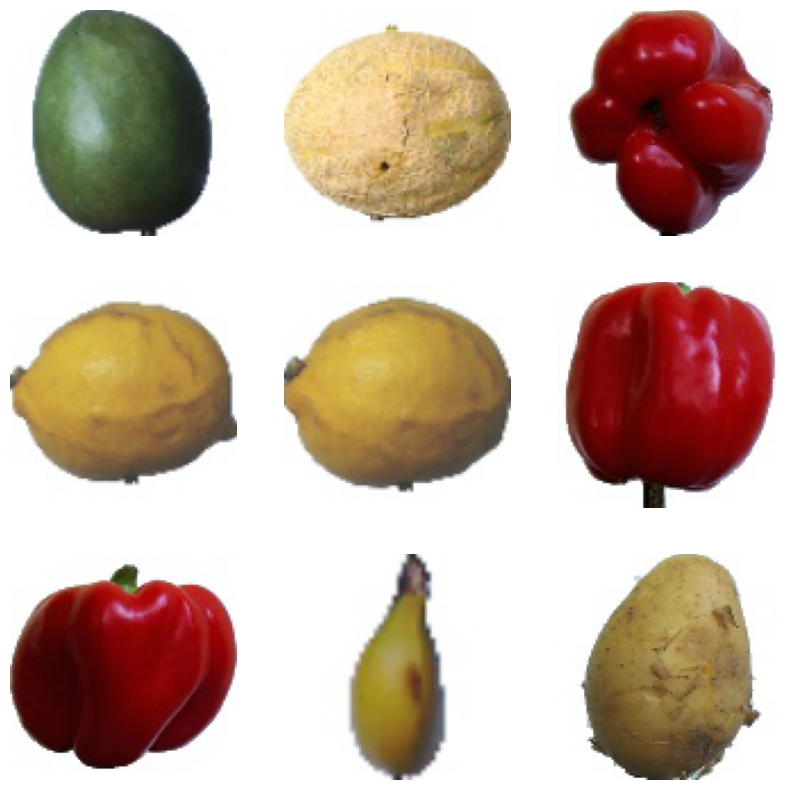

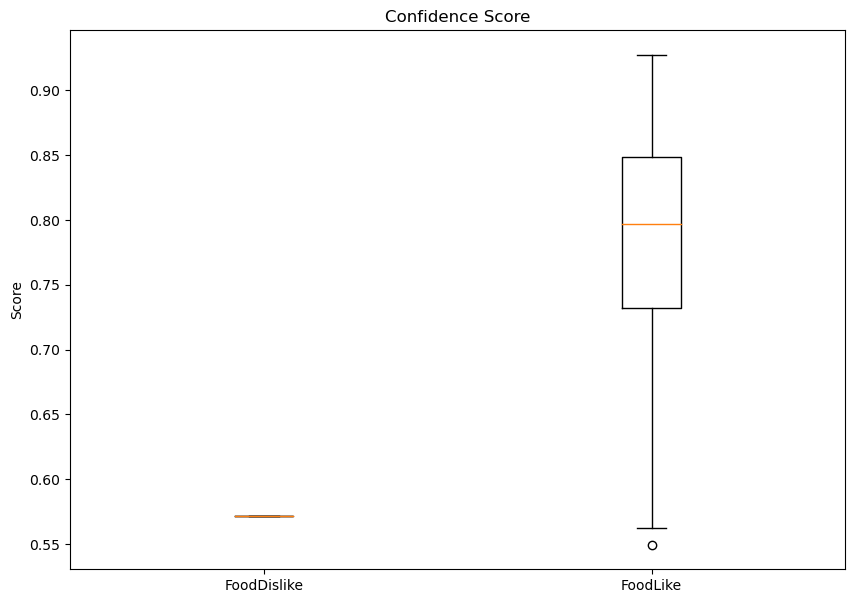

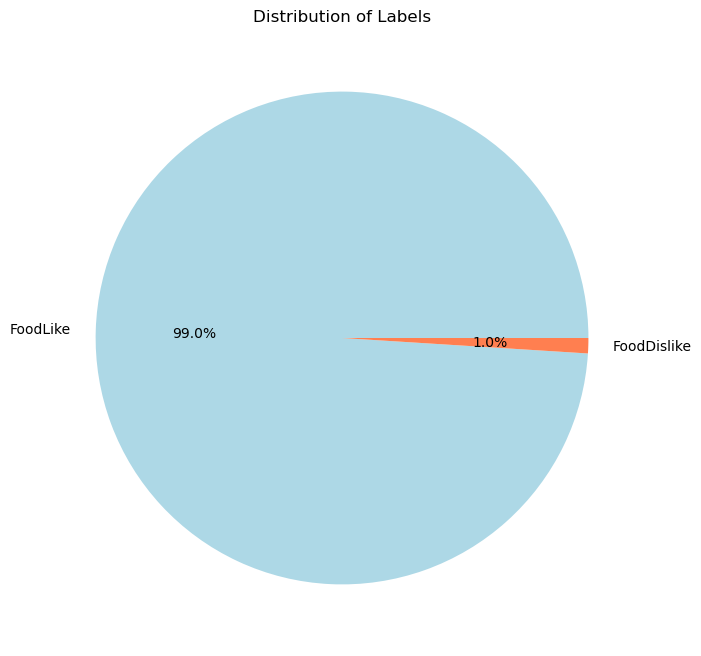

In [278]:
likeIT = glob.glob("likeDislike-Test\likeIT/*.jpg")
testLIT = classifer(likeIT)
dftestLIT = pd.DataFrame({'score':testLIT[0],'label' :testLIT[1]})
makePlots(dftestLIT)

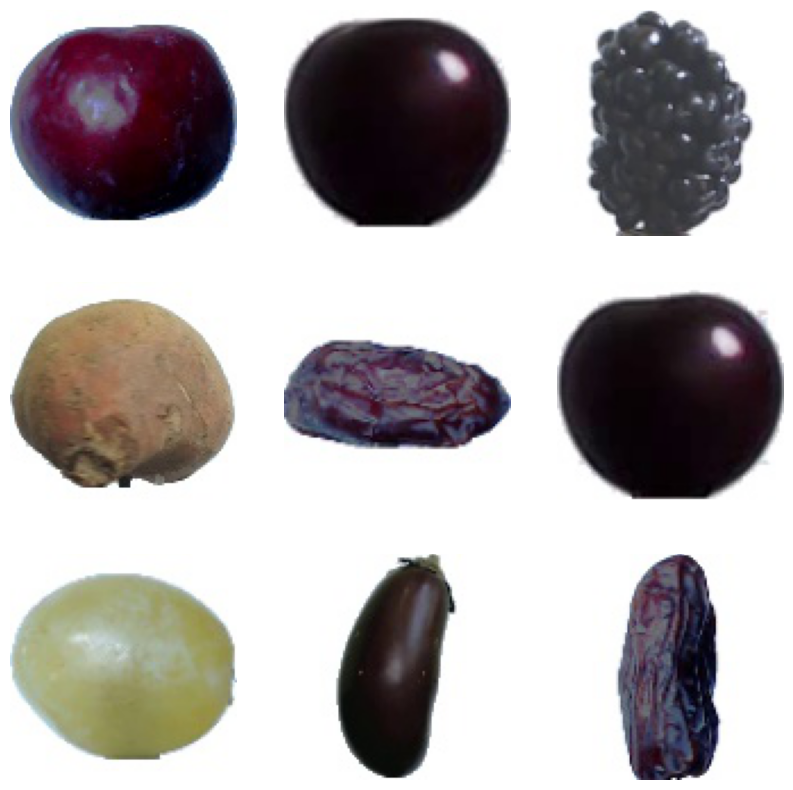

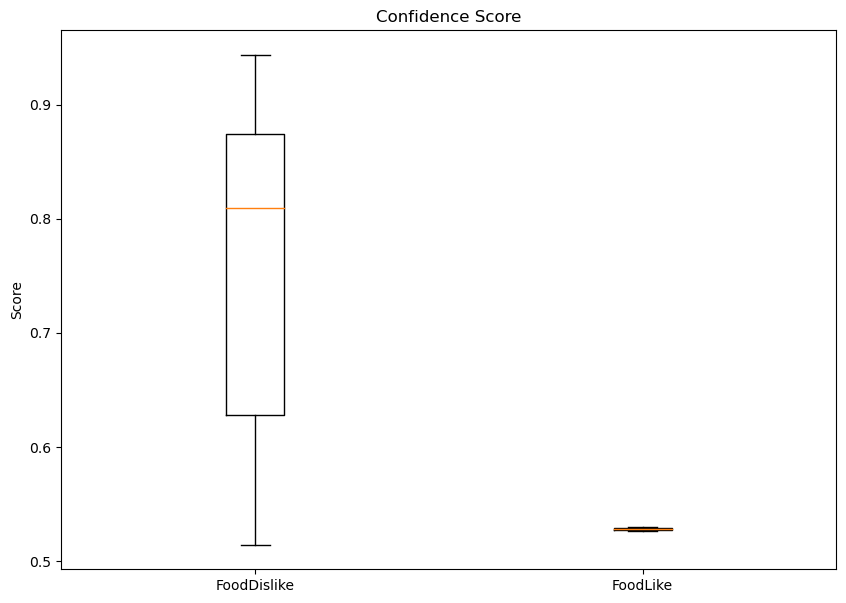

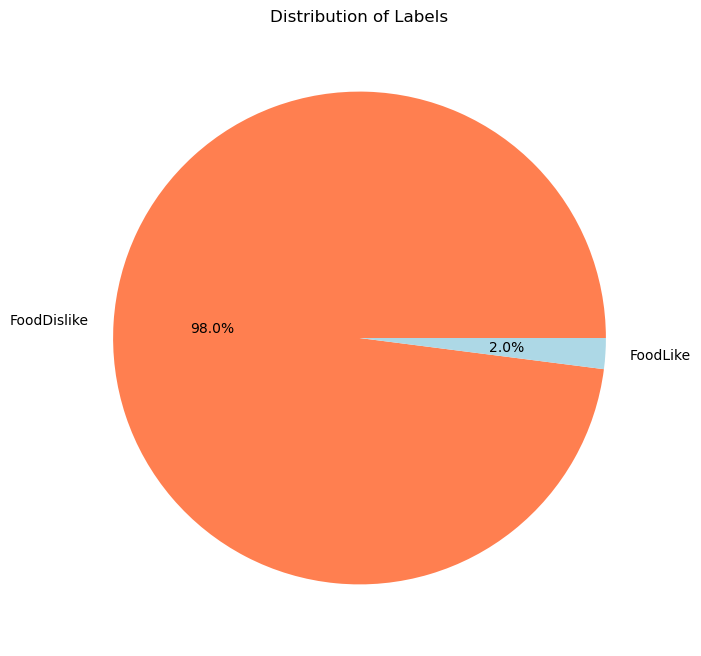

In [279]:
dislikeIT = glob.glob("likeDislike-Test\dislikeIT/*.jpg")
testDIT = classifer(dislikeIT)
dftestDIT = pd.DataFrame({'score':testDIT[0],'label' :testDIT[1]})
makePlots(dftestDIT)

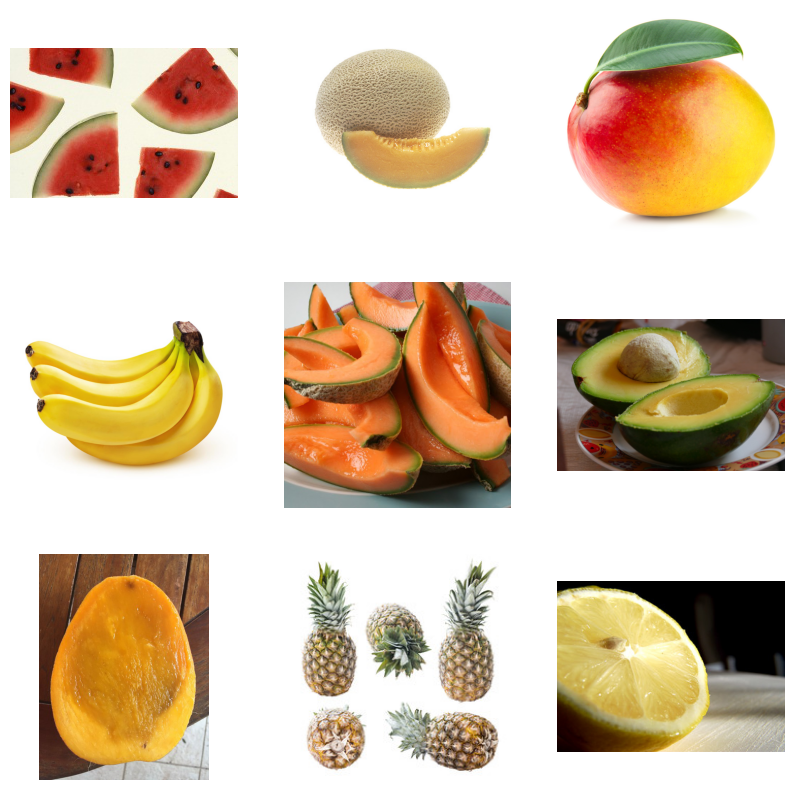

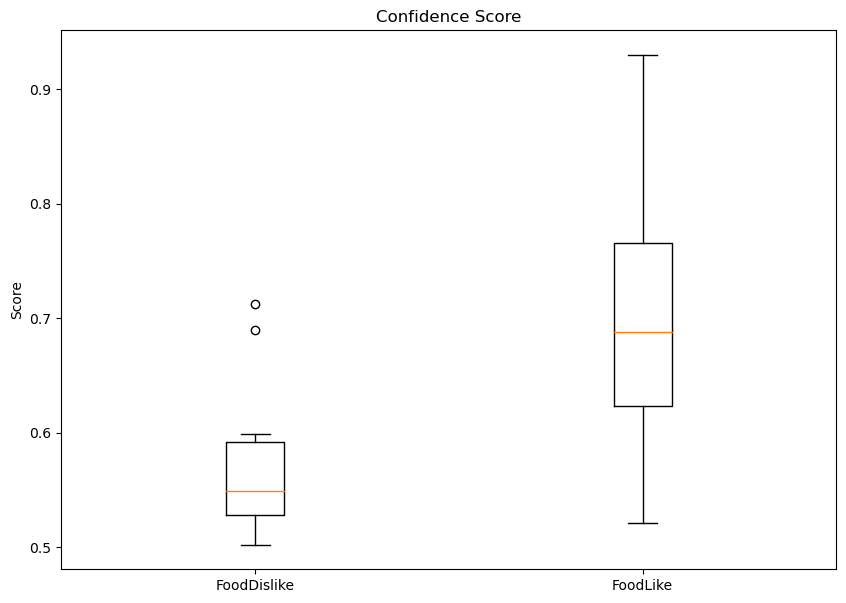

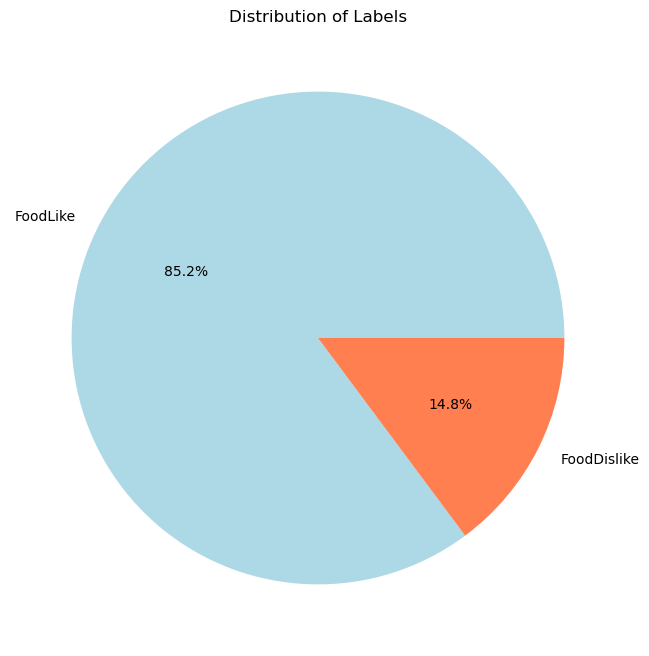

In [280]:
likeITnew = glob.glob("likeDislike-Test\likeITnew/*.jpg")
testLITnew = classifer(likeITnew)
dftestLITnew = pd.DataFrame({'score':testLITnew[0],'label' :testLITnew[1]})
makePlots(dftestLITnew)

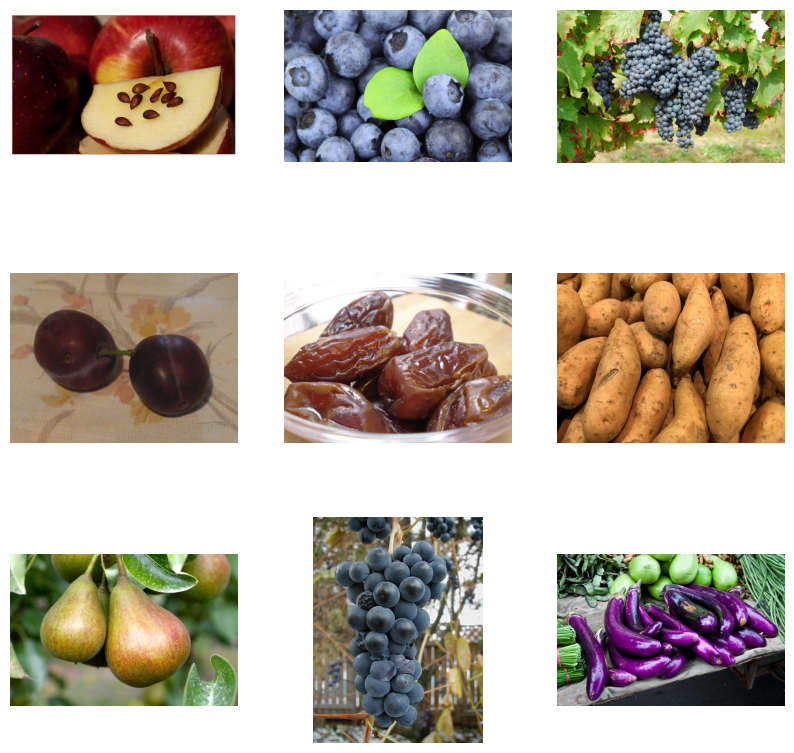

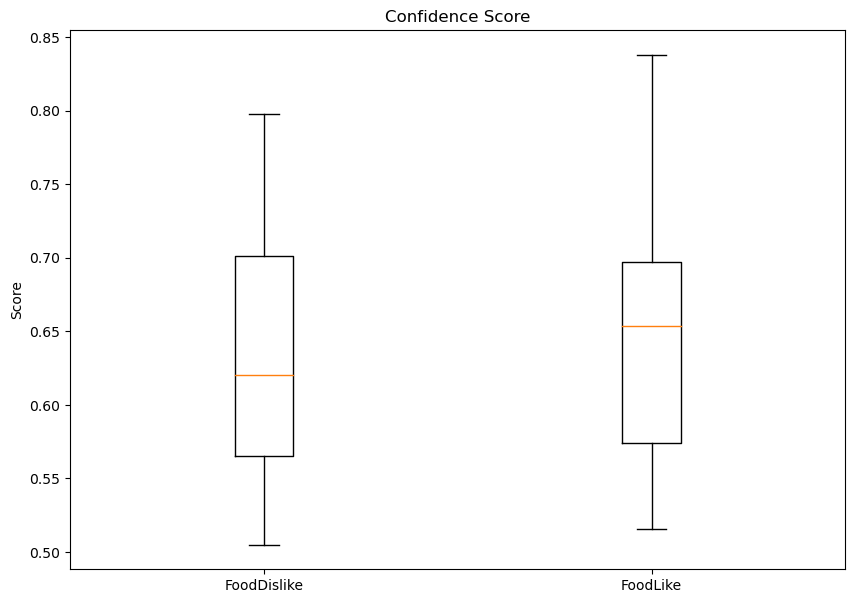

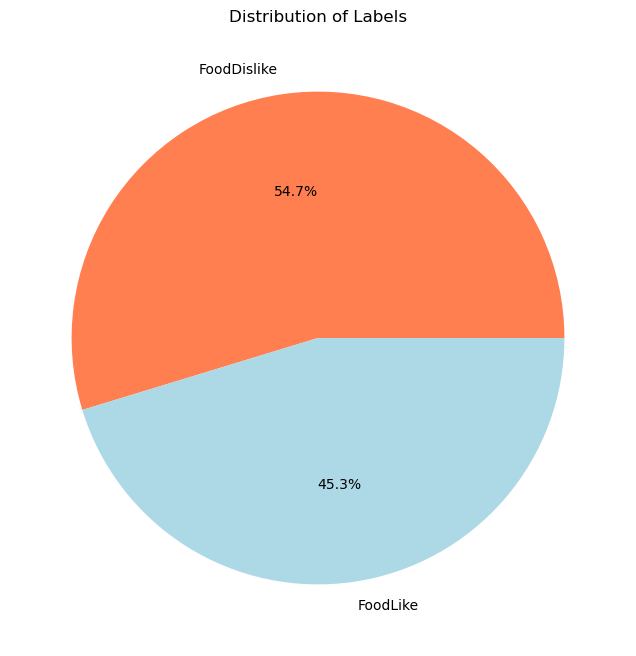

In [281]:
dislikeITnew = glob.glob("likeDislike-Test\dislikeITnew/*.jpg")
testDITnew = classifer(dislikeITnew)
#print(testDITnew)
dftestDITnew = pd.DataFrame({'score':testDITnew[0],'label' :testDITnew[1]})
makePlots(dftestDITnew)

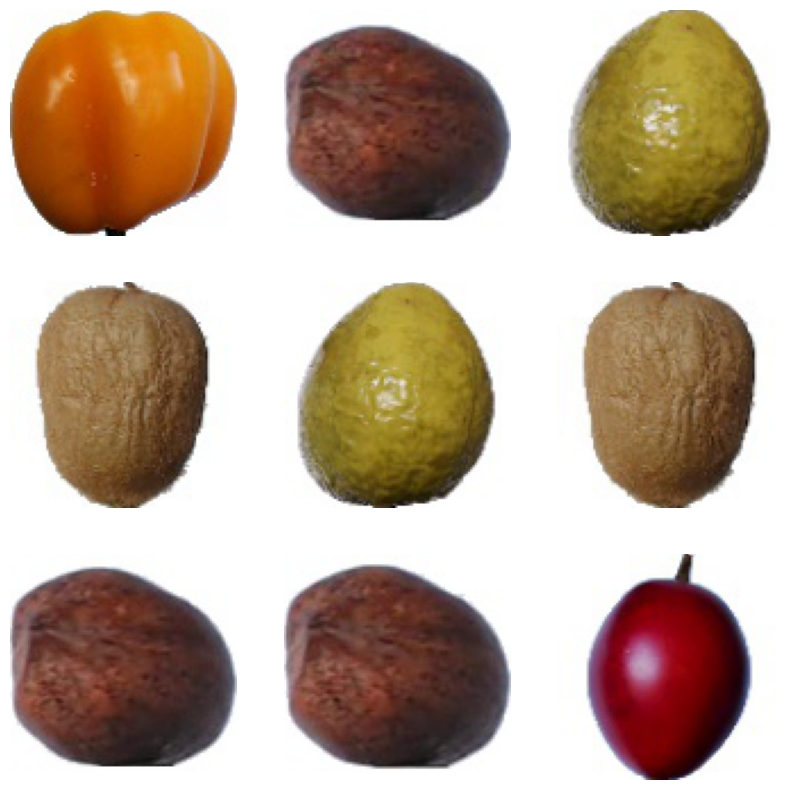

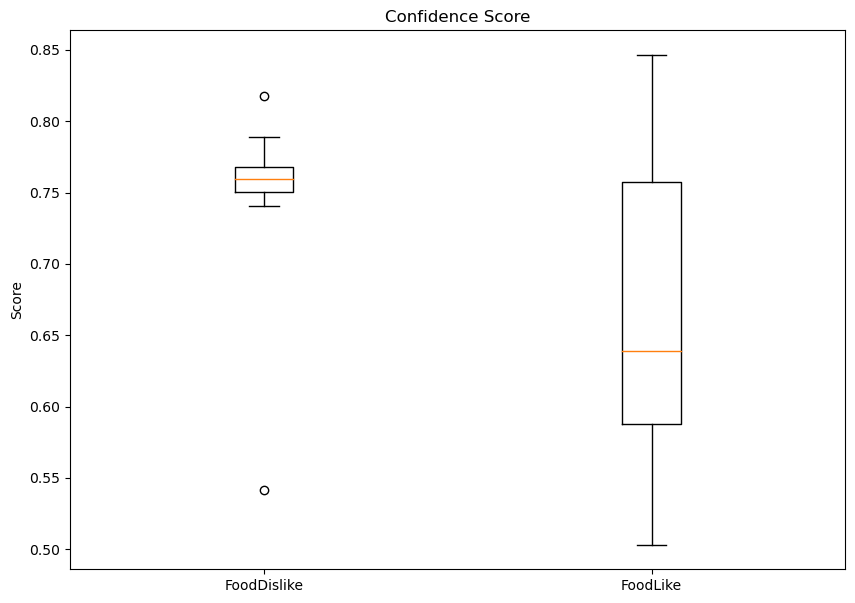

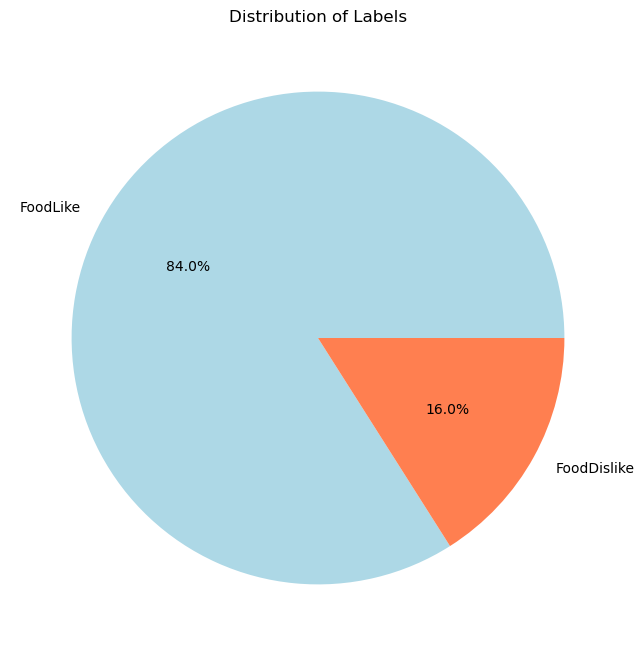

In [282]:
likeNIT = glob.glob("likeDislike-Test\likeNIT/*.jpg")
testLNIT = classifer(likeNIT)
dftestLNIT = pd.DataFrame({'score':testLNIT[0],'label' :testLNIT[1]})
makePlots(dftestLNIT)

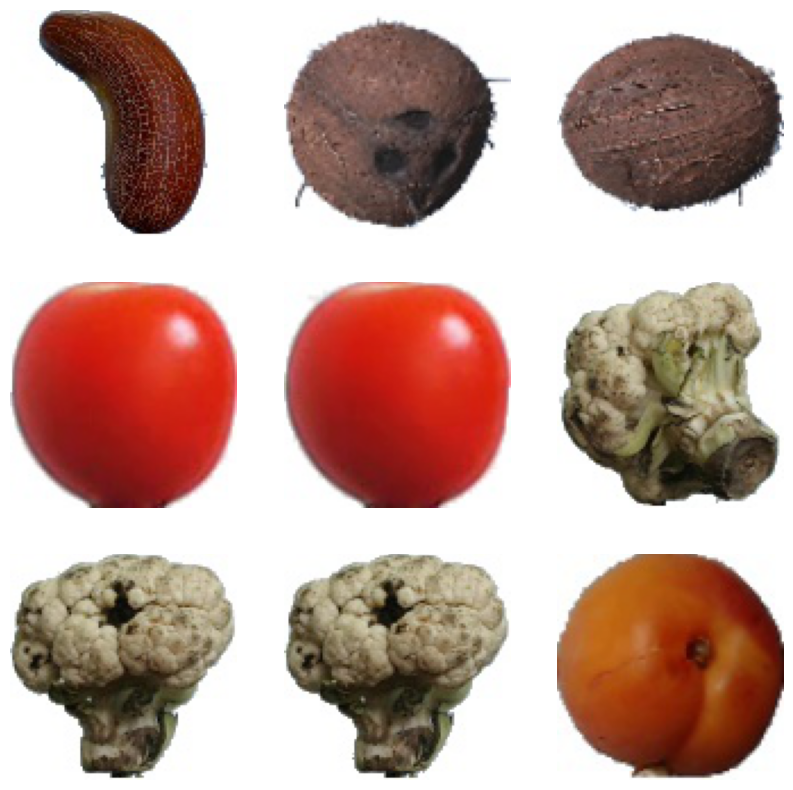

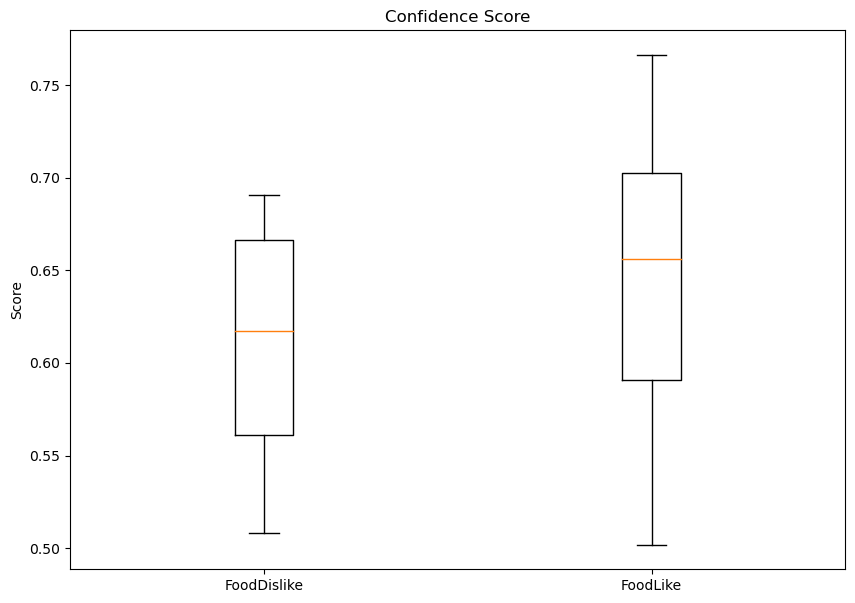

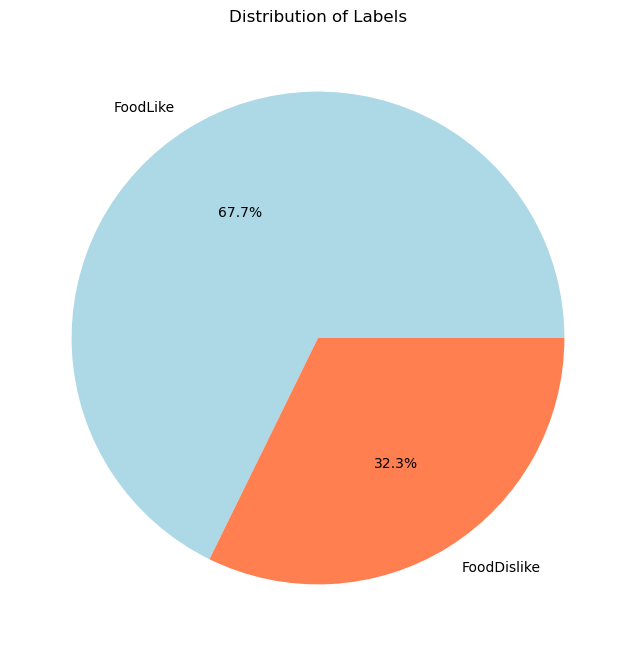

In [283]:
dislikeNIT = glob.glob("likeDislike-Test\dislikeNIT/*.jpg")
testDNIT = classifer(dislikeNIT)
#print(testDNIT)
dftestDNIT = pd.DataFrame({'score':testDNIT[0],'label' :testDNIT[1]})
makePlots(dftestDNIT)

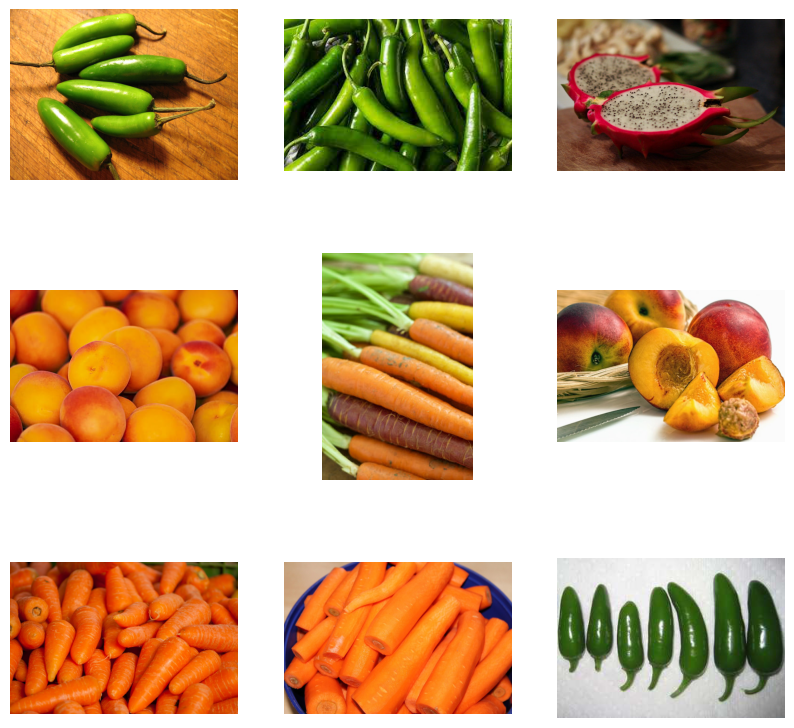

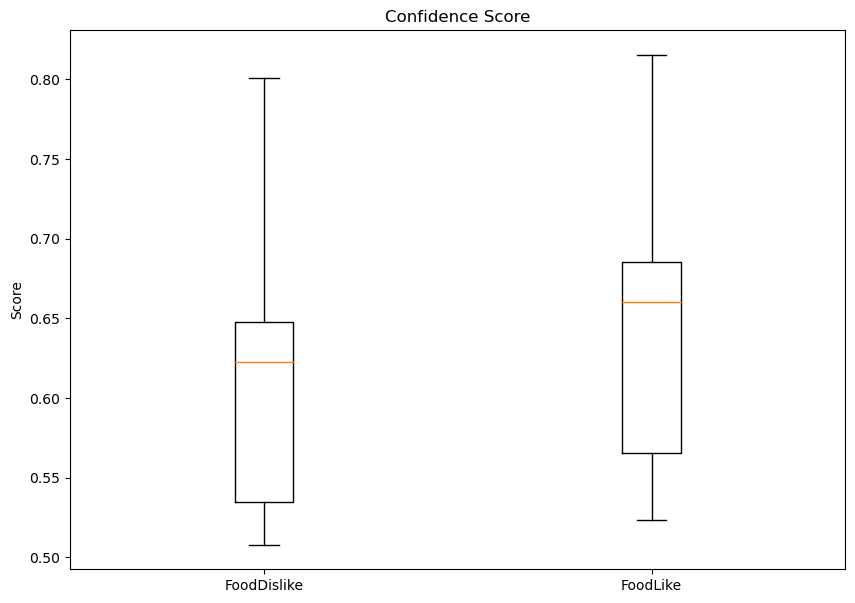

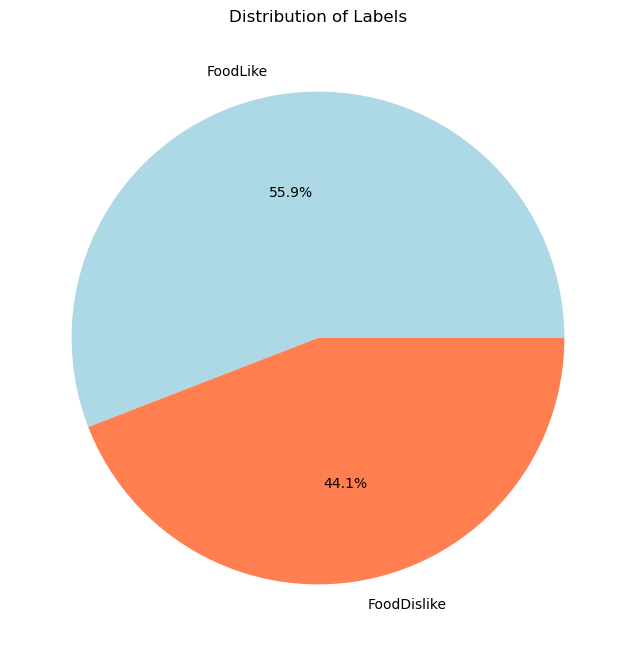

In [284]:
likeNITnew = glob.glob("likeDislike-Test\likeNITnew/*.jpg")
testLNITnew = classifer(likeNITnew)
#print(testLNITnew)
dftestLNITnew = pd.DataFrame({'score':testLNITnew[0],'label' :testLNITnew[1]})
makePlots(dftestLNITnew)

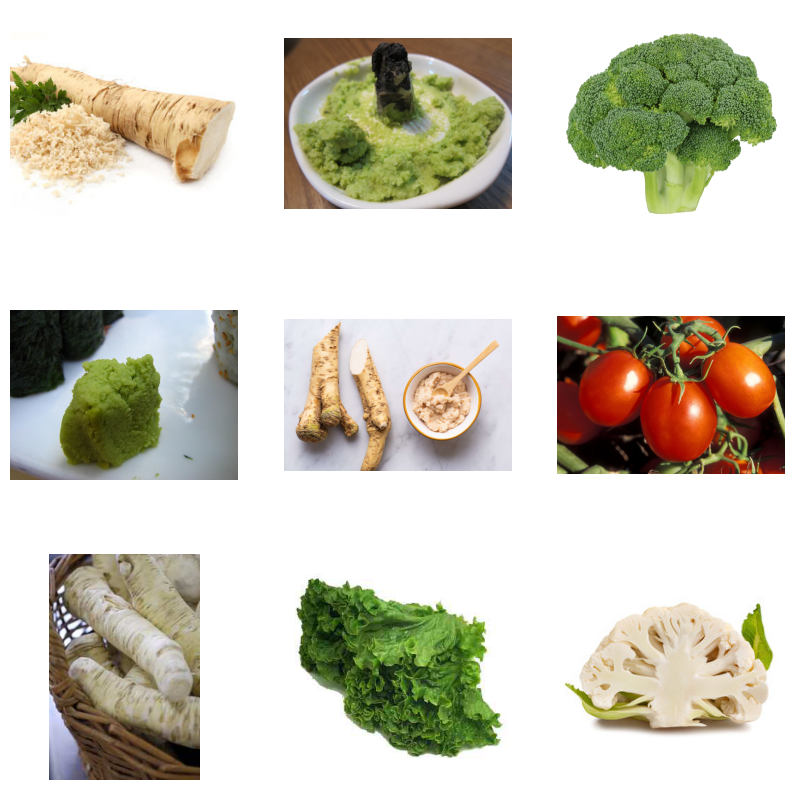

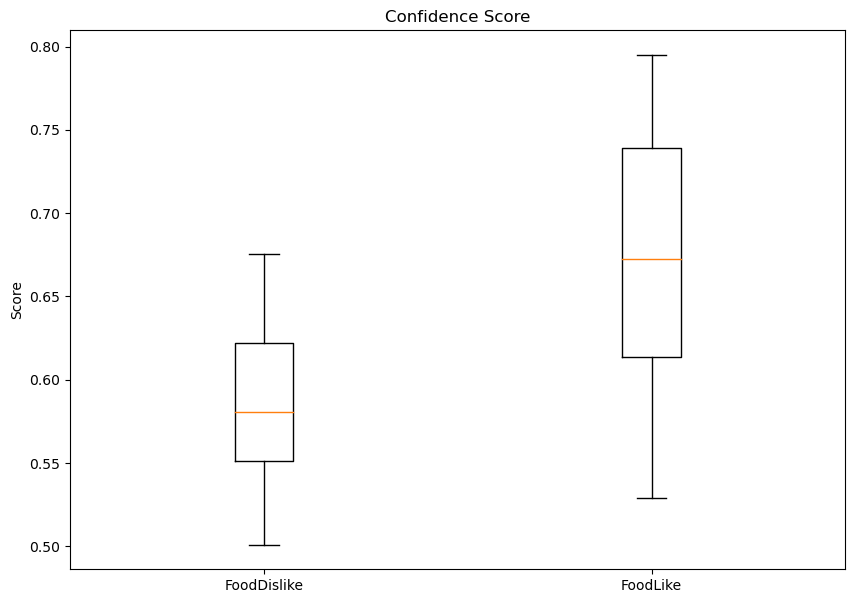

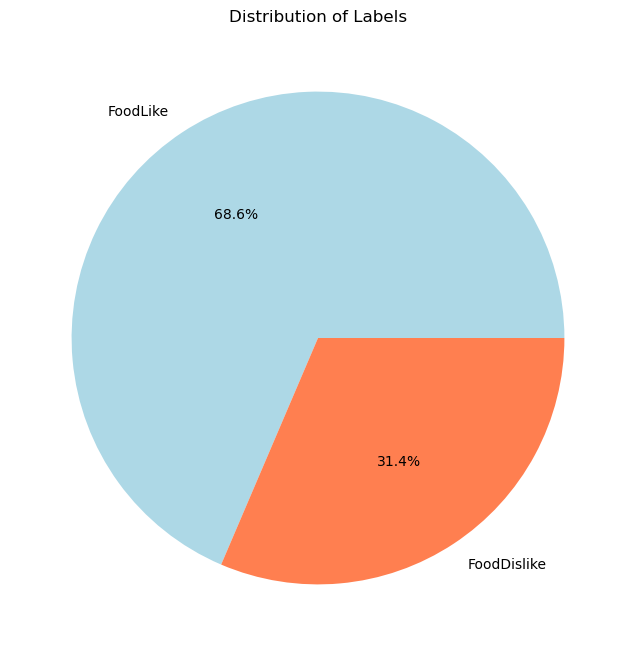

In [285]:
dislikeNITnew = glob.glob("likeDislike-Test\dislikeNITnew/*.jpg")
testDNITnew = classifer(dislikeNITnew)
#print(testDNITnew)
dftestDNITnew = pd.DataFrame({'score':testDNITnew[0],'label' :testDNITnew[1]})
makePlots(dftestDNITnew)

Below we retrieve the accuracy score for each test we ran and plot it into a bar plot.

In [287]:
print("----------------------")
accLIT = testLIT[2] / (testLIT[2] + testLIT[3])
print(accLIT)

accDIT = testDIT[3] / (testDIT[2] + testDIT[3])
print(accDIT)

accLITnew = testLITnew[2] / (testLITnew[2] + testLITnew[3])
print(accLITnew)

accDITnew = testDITnew[3] / (testDITnew[2] + testDITnew[3]) 
print(accDITnew)

accLNIT = testLNIT[2] / (testLNIT[2] + testLNIT[3])
print(accLNIT)

accDNIT = testDNIT[3] / (testDNIT[2] + testDNIT[3])
print(accDNIT)

accLNITnew = testLNITnew[2] / (testLNITnew[2] + testLNITnew[3])
print(accLNITnew)

accDNITnew = testDNITnew[3] / (testDNITnew[2] + testDNITnew[3])
print(accDNITnew)

----------------------
0.99
0.9797979797979798
0.8518518518518519
0.5471698113207547
0.84
0.3225806451612903
0.5588235294117647
0.3142857142857143


Below is the bar plot created for each test we ran based on Liked or Disliked labels.

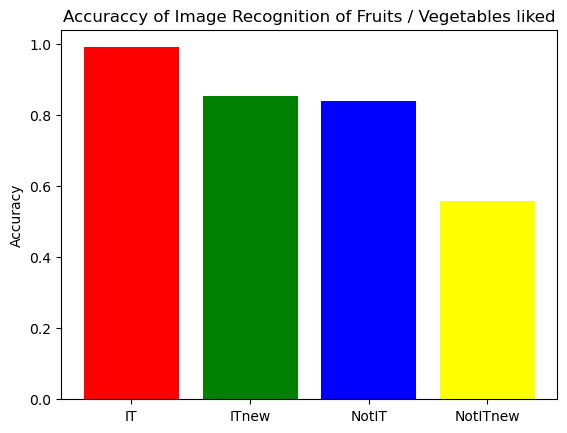

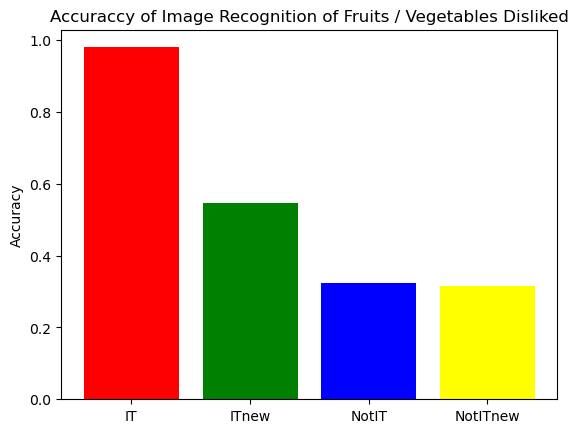

In [276]:
import numpy as np
import matplotlib.pyplot as plt 
xLike = ['IT','ITnew','NotIT','NotITnew']
xDislike = ['IT','ITnew','NotIT','NotITnew']

colors = ('red','green','blue','yellow')

accLike = (accLIT,accLITnew,accLNIT,accLNITnew)
#print(accLike)
accDislike = (accDIT,accDITnew,accDNIT,accDNITnew)
#print(accDislike)

plt.bar(xLike, accLike, width=0.8, color = colors)
plt.ylabel('Accuracy')
plt.title('Accuraccy of Image Recognition of Fruits / Vegetables liked')
#plt.legend(label = likeLabel,loc = 'upper right')
plt.show()

plt.bar(xDislike, accDislike, width=0.8, color = colors)
plt.ylabel('Accuracy')
plt.title('Accuraccy of Image Recognition of Fruits / Vegetables Disliked')
plt.show()

Below is the function used to retrieve the median, max, and min values of each dataset

In [318]:
dftestLIT
dftestDIT
dftestLITnew
dftestDITnew
dftestLNIT
dftestDNIT
dftestLNITnew
dftestDNITnew
def dfinfo(df):
    medianD = df['score'].where(df['label']=="FoodDislike").median()
    maxD = df['score'].where(df['label']=="FoodDislike").max()
    minD = df['score'].where(df['label']=="FoodDislike").min()
    medianL = df['score'].where(df['label']=="FoodLike").median()
    maxL = df['score'].where(df['label']=="FoodLike").max()
    minL = df['score'].where(df['label']=="FoodLike").min()
    return f'{minD:.2f},{maxD:.2f},{medianD:.2f},{minL:.2f},{maxL:.2f},{medianL:.2f}'

In [319]:
print(dfinfo(dftestLIT))
print(dfinfo(dftestDIT))
print(dfinfo(dftestLITnew))
print(dfinfo(dftestDITnew))
print(dfinfo(dftestLNIT))
print(dfinfo(dftestDNIT))
print(dfinfo(dftestLITnew))
print(dfinfo(dftestDNITnew))

0.57,0.57,0.57,0.55,0.93,0.80
0.51,0.94,0.81,0.53,0.53,0.53
0.50,0.71,0.55,0.52,0.93,0.69
0.50,0.80,0.62,0.52,0.84,0.65
0.54,0.82,0.76,0.50,0.85,0.64
0.51,0.69,0.62,0.50,0.77,0.66
0.50,0.71,0.55,0.52,0.93,0.69
0.50,0.68,0.58,0.53,0.80,0.67
